In [1]:
import pandas as pd
import random
from torchvision.transforms import ToPILImage, Resize, ToTensor
from torchvision.utils import make_grid
from torch import Tensor
from PIL import Image, ImageDraw
from glob import glob
from tqdm import tqdm
import random
import os
from scipy.spatial.distance import cdist
#from sentence_transformers import SentenceTransformer
import zipfile
import torch
import numpy as np
import matplotlib.pyplot as plt
import shutil
import unicodedata
import cv2
import torch.nn.functional as F
import faiss



In [2]:
METADATA_PATH = 'DDB_2M'

In [3]:
dfdb_meta = pd.read_parquet(f'{METADATA_PATH}/metadata.parquet', columns=['image_name', 'prompt', 'width', 'height'])


In [4]:
def is_english_only(string):
    for s in string:
        cat = unicodedata.category(s)         
        if not cat in ['Ll', 'Lu', 'Nd', 'Po', 'Pd', 'Zs']:
            return False
    return True

In [5]:

# df = df[(df['width'] == 512) & (df['height'] == 512)]
dfdb_meta['prompt'] = dfdb_meta['prompt'].str.strip()
dfdb_meta = dfdb_meta[dfdb_meta['prompt'].map(lambda x: len(x.split())) >= 5]
dfdb_meta = dfdb_meta[~dfdb_meta['prompt'].str.contains('^(?:\s*|NULL|null|NaN)$', na=True)]
dfdb_meta = dfdb_meta[dfdb_meta['prompt'].apply(is_english_only)]
#dfdb_meta['head'] = dfdb_meta['prompt'].str[:15]
#dfdb_meta['tail'] = dfdb_meta['prompt'].str[-15:]
#dfdb_meta.drop_duplicates(subset='head', inplace=True)
#dfdb_meta.drop_duplicates(subset='tail', inplace=True)
dfdb_meta.reset_index(drop=True, inplace=True)

# for i in tqdm(range(1, 2000, 100)):
#     image_dir = f'/kaggle/input/diffusiondb-2m-part-{str(i).zfill(4)}-to-{str(i+99).zfill(4)}-of-2000/'
#     images = os.listdir(image_dir)
#     dfdb_meta.loc[dfdb_meta['image_name'].isin(images), 'filepath'] = image_dir + dfdb_meta['image_name']

#dfdb_meta = dfdb_meta[['filepath', 'prompt']].copy()
#assert not dfdb_meta['filepath'].isnull().any()

In [16]:
dfdb_meta.describe

<bound method NDFrame.describe of                                        image_name   
0        2217ccbd-a1c6-47ac-9a2d-79649727c834.png  \
1        c78807b7-d55a-4a2d-a6b6-9192b18941ad.png   
2        dc71658a-5e4b-4dca-861a-e1535510348b.png   
3        48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png   
4        601d9792-eccd-4850-97a7-edbe91d3464c.png   
...                                           ...   
1786266  13b5e66b-8f41-4c2e-9804-1395edaef90a.png   
1786267  e2a3d527-6d44-4164-a212-d0209d7f4dc3.png   
1786268  f7542e54-ec7b-4345-a646-78279c88a9f1.png   
1786269  4ee0b70f-d9e9-4eed-b014-4006542cd58a.png   
1786270  28f80982-8d10-40bf-818b-fee951b496d0.png   

                                                    prompt  width  height   
0        a portrait of a female robot made from code, v...    512     512  \
1        a portrait of a female robot made from a cloud...    512     512   
2             only memories remain, trending on artstation    512     512   
3                    

In [7]:
import os
import zipfile
import shutil

# Modify these paths to match your directories
zip_files_folder = "H:/585pj/DDB_2M/"
output_folder = "H:/585pj/DDB_2M/images/"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through the zip files
for i in range(1, 2000):
    if i==1:
        continue
    idx = str(i).zfill(6)

    # Construct the zip file path
    zip_file_path = os.path.join(zip_files_folder, f"part-{idx}.zip")

    # Extract the zip file to the output folder
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

    # Delete the original zip file
    os.remove(zip_file_path)



FileNotFoundError: [Errno 2] No such file or directory: 'H:/585pj/DDB_2M/part-000002.zip'

In [8]:
# Update the 'filepath' column for each image in the output folder
images = os.listdir(output_folder)
dfdb_meta.loc[dfdb_meta['image_name'].isin(images), 'filepath'] = output_folder + dfdb_meta['image_name']

# Print the names of missing images
missing_images = dfdb_meta[dfdb_meta['filepath'].isnull()]['image_name']
print("Missing images:", missing_images)

# Filter out rows with missing images
dfdb_meta = dfdb_meta.dropna(subset=['filepath']).reset_index(drop=True)

# Make sure there are no null values in the 'filepath' column
assert not dfdb_meta['filepath'].isnull().any()

Missing images: 1786271    ceb9148e-baf9-4da4-94ed-80e382391723.png
1786272    6ea8ada5-f469-4ec7-81b4-d9ad0b2d0354.png
1786273    c1603487-9660-4e8b-a886-50460228b3ad.png
1786274    dbeaf1e3-3cd4-4b33-9ac0-8706bcb53869.png
1786275    6e14add8-3887-4b80-af46-6c20090be2f4.png
                             ...                   
1787201    256b1060-7069-456e-b18e-ad7c0f6d46b0.png
1787202    33914bb5-f05d-426c-b818-320aadf08b3f.png
1787203    4a34854e-e117-4b69-b1da-cc74534524c0.png
1787204    d4ae6d4f-762c-42f0-9481-a1c233e6a541.png
1787205    0ae508b1-f140-48c9-9da4-a124967215cf.png
Name: image_name, Length: 935, dtype: object


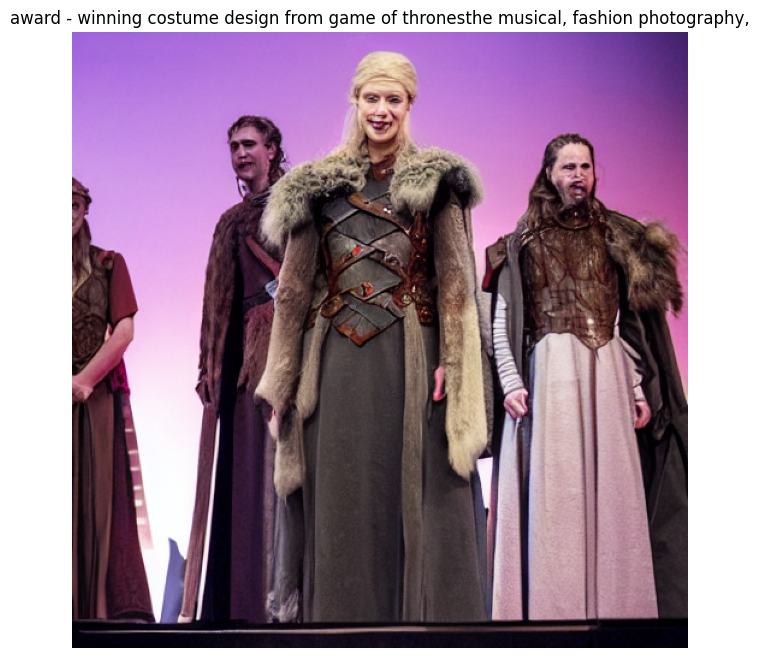

In [9]:
# Select a random image from the DataFrame
random_image = dfdb_meta.sample(n=1).iloc[0]

# Get the image filepath and prompt
image_path = random_image['filepath']
prompt = random_image['prompt']

# Open the image
image = Image.open(image_path)

# Convert the image to a NumPy array and normalize its values
image_data = np.array(image) / 255.0

# Create a figure and axis for displaying the image
fig, ax = plt.subplots(figsize=(8, 8))

# Display the image and set the title
ax.imshow(image_data)
ax.set_title(prompt, wrap=True)
ax.set_axis_off()

# Show the image
plt.show()

In [10]:
from sentence_transformers import SentenceTransformer

In [11]:
# Load the all-MiniLM-L6-v2 model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Move the model to the GPU if available
if torch.cuda.is_available():
    model = model.to('cuda')

# Compute the embeddings for the prompts
prompts = dfdb_meta['prompt'].tolist()
vector = model.encode(prompts, batch_size=1024, show_progress_bar=True, device="cuda", convert_to_tensor=True)



Batches:   0%|          | 0/1745 [00:00<?, ?it/s]

In [12]:
del model

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
threshold = 0.95
n_neighbors = 1000
batch_size = 1000
similar_vectors = []

# Create a GPU index
gpu_res = faiss.StandardGpuResources()  # Create GPU resources
gpu_index = faiss.GpuIndexFlatIP(gpu_res, 384)  # Create a GPU-based index

# Normalize the input vector and add it to the GPU index
gpu_index.add(F.normalize(vector).cpu().numpy())


# Perform the search on the GPU
for i in tqdm(range(0, len(vector), batch_size)):
    batch_data = vector.cpu().numpy()[i:i + batch_size]
    similarities, indices = gpu_index.search(batch_data, n_neighbors)

    for j in range(similarities.shape[0]):
        close_vectors = indices[j, similarities[j] >= threshold]
        index_base = i
        close_vectors = close_vectors[close_vectors != index_base + j]
        similar_vectors.append((index_base + j, close_vectors))

# Added a new column "index" to dfdb_meta
dfdb_meta['index'] = range(len(dfdb_meta))

# Filter out the rows based on the indices of similar_vectors
df_filtered = dfdb_meta[~dfdb_meta['index'].isin(np.unique(np.concatenate([x for _, x in similar_vectors])))]

# Reset the index after filtering
df_filtered.reset_index(drop=True, inplace=True)

100%|██████████| 1787/1787 [15:39<00:00,  1.90it/s]


,image_name,prompt,width,height,filepath,index
0,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",512,512,H:/585pj/DDB_2M/images/dc71658a-5e4b-4dca-861a...,2
1,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,512,768,H:/585pj/DDB_2M/images/601d9792-eccd-4850-97a7...,4
2,3c586acb-14dc-43df-8900-954c336f01b3.png,a dog doing weights on fire. epic oil painting.,512,768,H:/585pj/DDB_2M/images/3c586acb-14dc-43df-8900...,5
3,2919b048-6f68-4ac7-a6d5-060d827abb77.png,a beautiful paint of cultists dancing surround...,512,512,H:/585pj/DDB_2M/images/2919b048-6f68-4ac7-a6d5...,7
4,454d7550-a6cf-4896-befb-e2449b281265.png,a stunning portrait of an asian samurai with l...,512,512,H:/585pj/DDB_2M/images/454d7550-a6cf-4896-befb...,10
...,...,...,...,...,...,...
733678,3447d416-aec2-4d6c-a707-e051fa5ebb59.png,album cover art for cocoon of space by akihiko...,512,512,H:/585pj/DDB_2M/images/3447d416-aec2-4d6c-a707...,1786259
733679,98479678-e963-48c7-ab21-9c456b96cb90.png,album cover art for butterflies pop art dream ...,512,512,H:/585pj/DDB_2M/images/98479678-e963-48c7-ab21...,1786260
733680,86433f6c-9cb5-4206-836c-35b046a2ea9d.png,a woman by frank auerbach,512,512,H:/585pj/DDB_2M/images/86433f6c-9cb5-4206-836c...,1786262
733681,13b5e66b-8f41-4c2e-9804-1395edaef90a.png,a photo of ironman fused with batman,512,704,H:/585pj/DDB_2M/images/13b5e66b-8f41-4c2e-9804...,1786266


In [19]:
df_filtered.to_csv('df_filtered.csv', index=False)

In [2]:
df_filtered=pd.read_csv('df_filtered.csv')

In [3]:
df_filtered

,image_name,prompt,width,height,filepath,index
0,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",512,512,H:/585pj/DDB_2M/images/dc71658a-5e4b-4dca-861a...,2
1,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,512,768,H:/585pj/DDB_2M/images/601d9792-eccd-4850-97a7...,4
2,3c586acb-14dc-43df-8900-954c336f01b3.png,a dog doing weights on fire. epic oil painting.,512,768,H:/585pj/DDB_2M/images/3c586acb-14dc-43df-8900...,5
3,2919b048-6f68-4ac7-a6d5-060d827abb77.png,a beautiful paint of cultists dancing surround...,512,512,H:/585pj/DDB_2M/images/2919b048-6f68-4ac7-a6d5...,7
4,454d7550-a6cf-4896-befb-e2449b281265.png,a stunning portrait of an asian samurai with l...,512,512,H:/585pj/DDB_2M/images/454d7550-a6cf-4896-befb...,10
...,...,...,...,...,...,...
733678,3447d416-aec2-4d6c-a707-e051fa5ebb59.png,album cover art for cocoon of space by akihiko...,512,512,H:/585pj/DDB_2M/images/3447d416-aec2-4d6c-a707...,1786259
733679,98479678-e963-48c7-ab21-9c456b96cb90.png,album cover art for butterflies pop art dream ...,512,512,H:/585pj/DDB_2M/images/98479678-e963-48c7-ab21...,1786260
733680,86433f6c-9cb5-4206-836c-35b046a2ea9d.png,a woman by frank auerbach,512,512,H:/585pj/DDB_2M/images/86433f6c-9cb5-4206-836c...,1786262
733681,13b5e66b-8f41-4c2e-9804-1395edaef90a.png,a photo of ironman fused with batman,512,704,H:/585pj/DDB_2M/images/13b5e66b-8f41-4c2e-9804...,1786266
